In [1]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset, load_metric
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import evaluate

In [2]:
dataset = load_dataset('imdb')

In [3]:
# Assuming you already have loaded the dataset
train_test_split = dataset['train'].train_test_split(test_size=0.2)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']


In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['text'], padding = 'max_length', truncation = True)

In [5]:
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Convert datasets to PyTorch tensors
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [6]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=0.03,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)


In [8]:
metric = evaluate.load('accuracy')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


In [9]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)


In [10]:
trainer.train()


Step,Training Loss
10,0.684000
20,0.695100
30,0.680900
40,0.683000
50,0.718300
60,0.704200
70,0.692900


TrainOutput(global_step=75, training_loss=0.6920073795318603, metrics={'train_runtime': 3381.772, 'train_samples_per_second': 0.177, 'train_steps_per_second': 0.022, 'total_flos': 157866633216000.0, 'train_loss': 0.6920073795318603, 'epoch': 0.03})

In [11]:
eval_results = trainer.evaluate()

print(f"Accuracy: {eval_results['eval_accuracy']:.4f}")


Accuracy: 0.4892


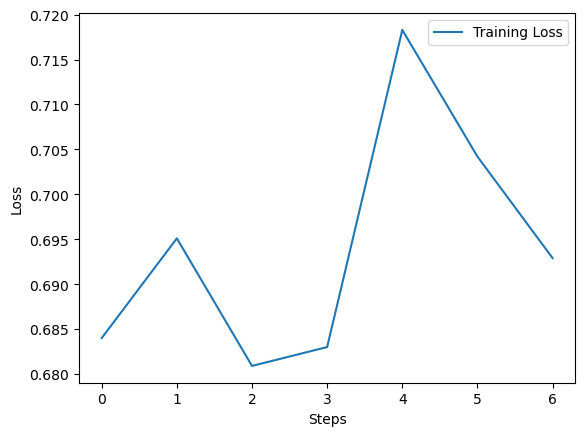

In [13]:
# Extract training loss from the log history
train_loss = [log['loss'] for log in logs if 'loss' in log]

# Plotting the training loss
plt.plot(range(len(train_loss)), train_loss, label='Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [14]:
print("Conclusion: The model achieved an accuracy of {:.4f}, showing its ability to handle sentiment analysis. Future work could involve fine-tuning on different datasets or exploring other transformer models.".format(eval_results['eval_accuracy']))

Conclusion: The model achieved an accuracy of 0.4892, showing its ability to handle sentiment analysis. Future work could involve fine-tuning on different datasets or exploring other transformer models.
